In [248]:
import networkx as nx
import numpy as np
import EoN
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from networkx.algorithms import community

In [250]:
# Define SBM with different configurations
sizes = [50, 50]  # Two communities of 50 nodes each

# Different SBM connection probabilities
sbm_low_inter = nx.stochastic_block_model(sizes, [[0.1, 0.001], [0.001, 0.1]])  # Sparse inter-community
sbm_balanced = nx.stochastic_block_model(sizes, [[0.1, 0.01], [0.01, 0.1]])      # Balanced connections
sbm_high_inter = nx.stochastic_block_model(sizes, [[0.1, 0.05], [0.05, 0.1]])    # Dense inter-community

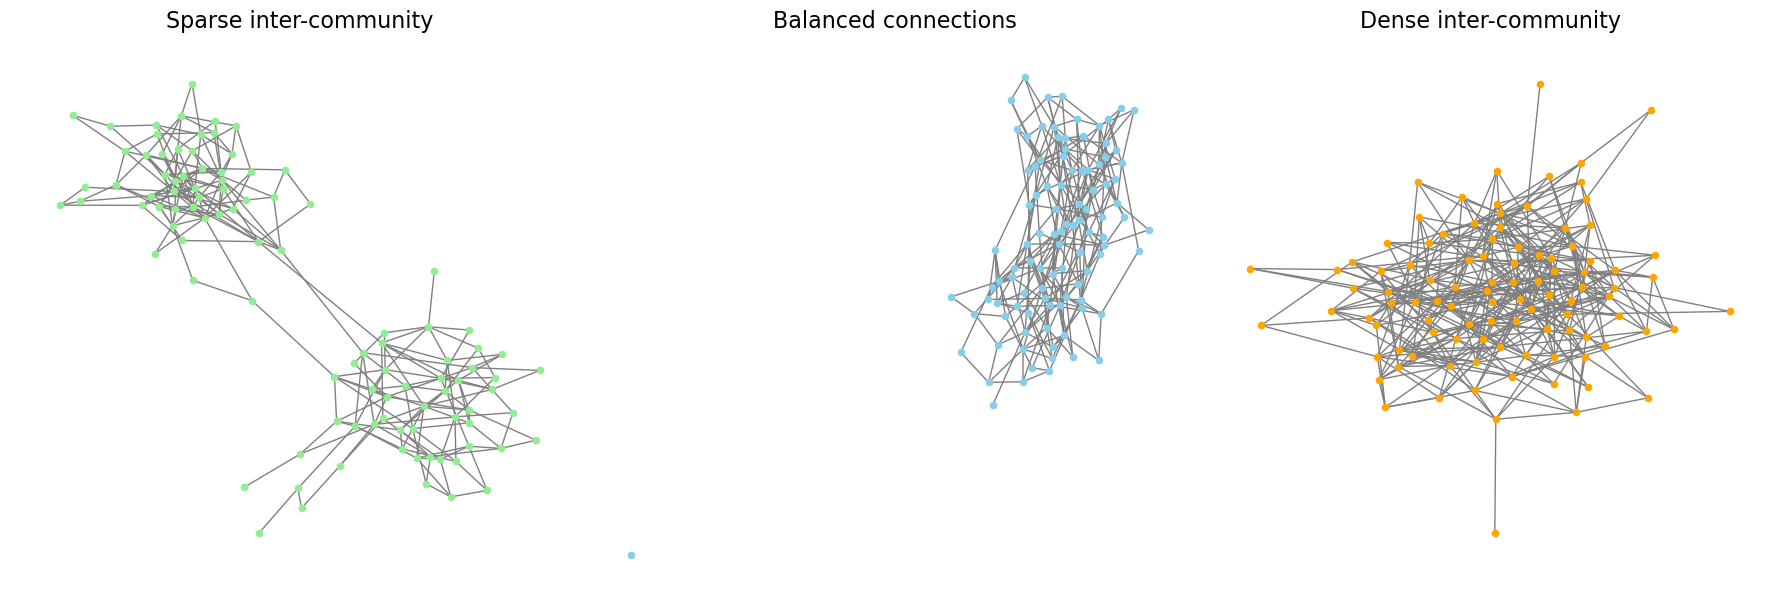

In [266]:

# Set up figure and subplots
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
nx.draw(sbm_low_inter, node_color='lightgreen', node_size=20, edge_color='gray', with_labels=False)
plt.title('Sparse inter-community', fontsize=16)  # Increased title font size

plt.subplot(1, 3, 2)
nx.draw(sbm_balanced, node_color='skyblue', node_size=20, edge_color='gray', with_labels=False)
plt.title('Balanced connections', fontsize=16)  # Increased title font size

plt.subplot(1, 3, 3)
nx.draw(sbm_high_inter, node_color='orange', node_size=20, edge_color='gray', with_labels=False)
plt.title('Dense inter-community', fontsize=16)  # Increased title font size

plt.tight_layout()
plt.show()


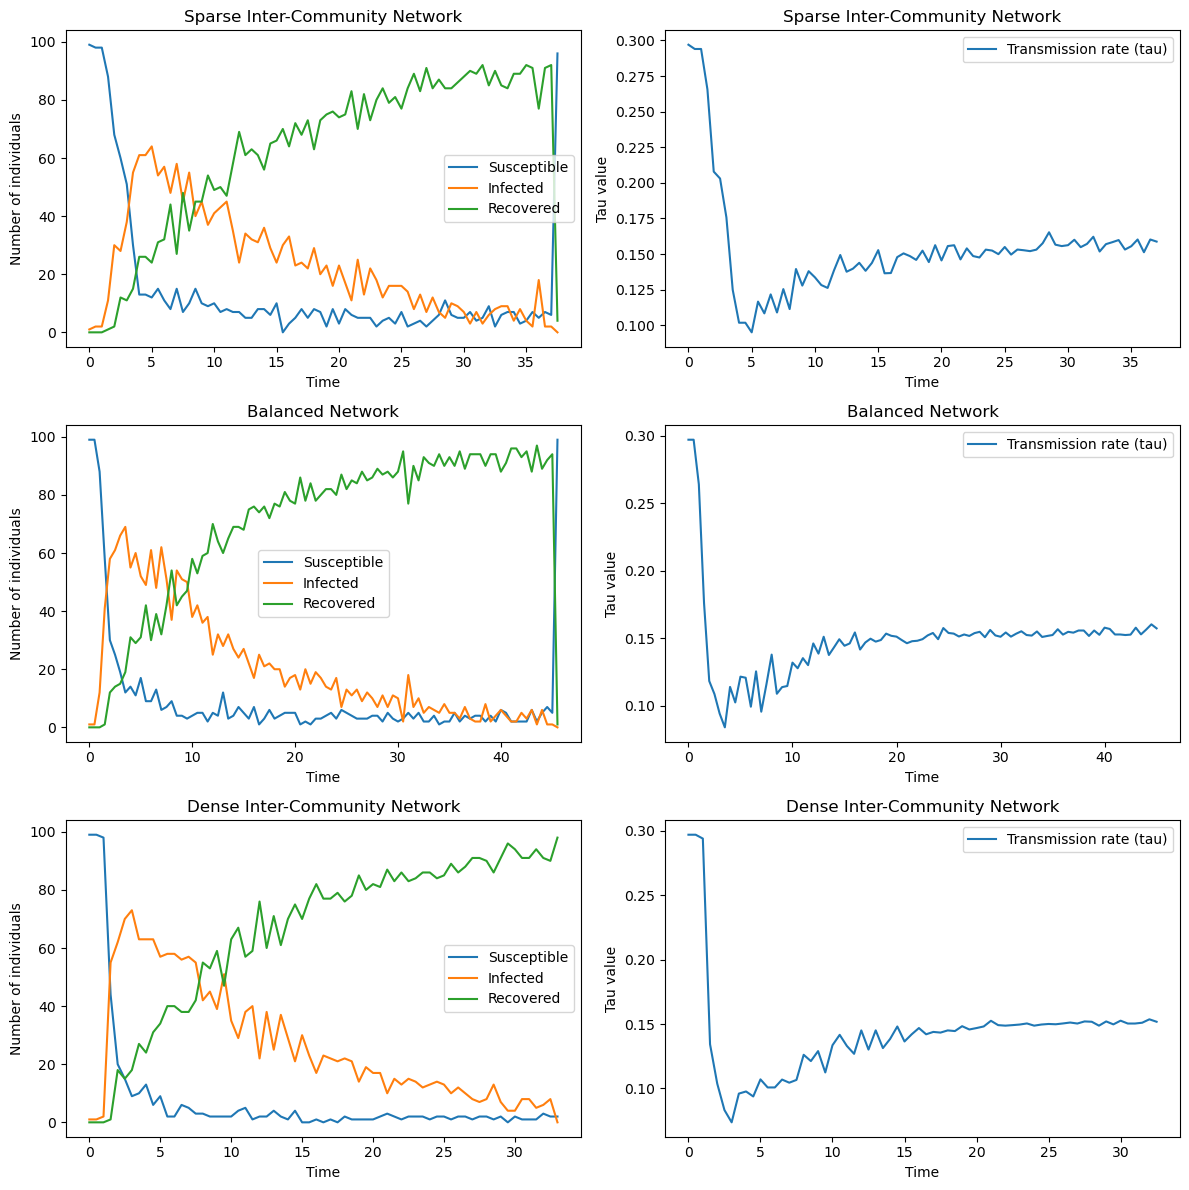

In [290]:
def dynamic_sir_simulation(N, initial_infected, gamma, base_tau, time_steps):

    # Initialize network types
    network_types = ['Sparse','Balanced','Dense']
    
    # Initialize simulation variables
    all_times, all_S, all_I, all_R, all_tau_history = [], [], [], [], []
    
    for network_type in network_types:
        # Create network
        if network_type == 'Sparse':
            G = sbm_low_inter
        elif network_type == 'Balanced':
            G = sbm_balanced
        else:
            G = sbm_high_inter
        
        # Initialize node states
        initial_infected_nodes = list(np.random.choice(range(N), size=initial_infected, replace=False))
        initial_status = {node: 'S' for node in G.nodes()}
        for node in initial_infected_nodes:
            initial_status[node] = 'I'
        
        # Initialize simulation variables
        tau_history = []
        current_time = 0
        current_status = initial_status.copy()
        
        times = [0]
        S = [N - initial_infected]
        I = [initial_infected]
        R = [0]
        
        def get_tau(t, current_status):
            """
            Calculate tau based on current state of the epidemic,
            accounting for both infected and recovered populations.
            """
            infected_count = sum(1 for status in current_status.values() if status == 'I')
            recovered_count = sum(1 for status in current_status.values() if status == 'R')
            
            infected_fraction = infected_count / N
            recovered_fraction = recovered_count / N
            
            # New dynamic tau rule incorporating both effects:
            # 1. Decrease due to current infected population (behavioral response)
            # 2. Decrease due to recovered population (immunity effect)
            infection_factor = 1 - infected_fraction
            immunity_factor = 1 - (recovered_fraction*0.5)  #  * 0.8 Recovered population reduces transmission by up to 80%
            
            new_tau = base_tau * infection_factor * immunity_factor
            
            # Ensure tau doesn't go too low (minimum 10% of base_tau)
            return max(0.1 * base_tau, new_tau)
        
        while current_time < time_steps:
            # Get current tau
            current_tau = get_tau(current_time, current_status)
            tau_history.append(current_tau)
            
            # Run a small time step
            delta_t = 0.5
            result = EoN.fast_SIR(G, current_tau, gamma, 
                                 initial_infecteds=initial_infected_nodes,
                                 return_full_data=True, 
                                 tmax=current_time + delta_t)
            
            # Update current state
            current_time += delta_t
            current_status = result.get_statuses(time=current_time)
            
            # Record results
            times.append(current_time)
            S.append(sum(1 for status in current_status.values() if status == 'S'))
            I.append(sum(1 for status in current_status.values() if status == 'I'))
            R.append(sum(1 for status in current_status.values() if status == 'R'))
            
            # Update initially infected nodes for next iteration
            initial_infected_nodes = [node for node, status in current_status.items() 
                                     if status == 'I']
            
            # Stop if no more infected individuals
            if I[-1] == 0:
                break
        
        all_times.append(np.array(times))
        all_S.append(np.array(S))
        all_I.append(np.array(I))
        all_R.append(np.array(R))
        all_tau_history.append(np.array(tau_history))
    
    return all_times, all_S, all_I, all_R, all_tau_history

# Example usage
if __name__ == "__main__":
    # Set parameters
    N = 100  # population size
    initial_infected = 1
    gamma = 0.1  # recovery rate
    base_tau = 0.3  # base transmission rate
    time_steps = 100
    
    # Run simulation
    all_times, all_S, all_I, all_R, all_tau_history = dynamic_sir_simulation(
        N, initial_infected, gamma, base_tau, time_steps
    )
    
    # Plot results (3x2 matrix)
    fig, axes = plt.subplots(3, 2, figsize=(12, 12))
    
    for i, (times, S, I, R, tau_history) in enumerate(zip(all_times, all_S, all_I, all_R, all_tau_history)):
        # Plot SIR curves
        axes[i, 0].plot(times, S, label='Susceptible')
        axes[i, 0].plot(times, I, label='Infected')
        axes[i, 0].plot(times, R, label='Recovered')
        axes[i, 0].set_title(f"{['Sparse Inter-Community', 'Balanced', 'Dense Inter-Community'][i]} Network")
        axes[i, 0].set_ylabel('Number of individuals')
        axes[i, 0].set_xlabel('Time')
        axes[i, 0].legend()
        
        # Plot tau values
        axes[i, 1].plot(times[:-1], tau_history, label='Transmission rate (tau)')
        axes[i, 1].set_title(f"{['Sparse Inter-Community', 'Balanced', 'Dense Inter-Community'][i]} Network")
        axes[i, 1].set_ylabel('Tau value')
        axes[i, 1].set_xlabel('Time')
        axes[i, 1].legend()
    
    plt.tight_layout()
    plt.show()

In [270]:
def dynamic_sir_simulation(N, initial_infected, gamma, base_tau, time_steps):
    
    # Initialize network types
    network_types = ['Sparse', 'Balanced', 'Dense']
    
    # Initialize simulation results
    results = []
    
    for network_type in network_types:
        # Run 100 simulations for each network type
        for _ in tqdm(range(1000), desc=f"Simulating {network_type} network", unit="simulation"):
            # Create network
            if network_type == 'Sparse':
                G = sbm_low_inter
            elif network_type == 'Balanced':
                G = sbm_balanced
            else:
                G = sbm_high_inter
            
            # Initialize node states
            initial_infected_nodes = list(np.random.choice(range(N), size=initial_infected, replace=False))
            initial_status = {node: 'S' for node in G.nodes()}
            for node in initial_infected_nodes:
                initial_status[node] = 'I'
            
            # Initialize simulation variables
            tau_history = []
            current_time = 0
            current_status = initial_status.copy()
            
            times = [0]
            S = [N - initial_infected]
            I = [initial_infected]
            R = [0]
            
            # # Time-Dependent Metrics (TDM)
            # tdm = {
            #     'S': [N - initial_infected],
            #     'I': [initial_infected],
            #     'R': [0],
            #     'tau': [base_tau]
            # }
            
            def get_tau(t, current_status):
                """
                Calculate tau based on current state of the epidemic,
                accounting for both infected and recovered populations.
                """
                infected_count = sum(1 for status in current_status.values() if status == 'I')
                recovered_count = sum(1 for status in current_status.values() if status == 'R')
                
                infected_fraction = infected_count / N
                recovered_fraction = recovered_count / N
                
                # New dynamic tau rule incorporating both effects:
                # 1. Decrease due to current infected population (behavioral response)
                # 2. Decrease due to recovered population (immunity effect)
                infection_factor = 1 - infected_fraction
                immunity_factor = 1 - (recovered_fraction * 0.5)
                
                new_tau = base_tau * infection_factor * immunity_factor
                
                # Ensure tau doesn't go too low (minimum 10% of base_tau)
                return max(0.1 * base_tau, new_tau)
            
            while current_time < time_steps:
                # Get current tau
                current_tau = get_tau(current_time, current_status)
                tau_history.append(current_tau)
                
                # Run a small time step
                delta_t = 0.5
                result = EoN.fast_SIR(G, current_tau, gamma, 
                                     initial_infecteds=initial_infected_nodes,
                                     return_full_data=True, 
                                     tmax=current_time + delta_t)
                
                # Update current state
                current_time += delta_t
                current_status = result.get_statuses(time=current_time)
                
                # Record results
                times.append(current_time)
                S.append(sum(1 for status in current_status.values() if status == 'S'))
                I.append(sum(1 for status in current_status.values() if status == 'I'))
                R.append(sum(1 for status in current_status.values() if status == 'R'))
                
                # # Update Time-Dependent Metrics (TDM)
                # tdm['S'].append(S[-1])
                # tdm['I'].append(I[-1])
                # tdm['R'].append(R[-1])
                # tdm['tau'].append(current_tau)
                
                # Update initially infected nodes for next iteration
                initial_infected_nodes = [node for node, status in current_status.items() 
                                         if status == 'I']
                
                # Stop if no more infected individuals
                if I[-1] == 0:
                    break
            
            # Collect simulation metrics
            peak_infection = max(I)
            time_to_peak = times[I.index(peak_infection)]
            outbreak_duration = times[-1] - times[0]
            
            results.append({
                'network_type': network_type,
                'peak_infection': peak_infection,
                'time_to_peak': time_to_peak,
                'outbreak_duration': outbreak_duration
                # 'S_history': tdm['S'],
                # 'I_history': tdm['I'],
                # 'R_history': tdm['R'],
                # 'tau_history': tdm['tau']
            })
    
    # Create a Pandas DataFrame from the results
    df = pd.DataFrame(results)
    return df

# Example usage
if __name__ == "__main__":
    # Set parameters
    N = 100  # population size
    initial_infected = 1
    gamma = 0.1  # recovery rate
    base_tau = 0.3  # base transmission rate
    time_steps = 100
    
    # Run simulation and get results
    results_df = dynamic_sir_simulation(N, initial_infected, gamma, base_tau, time_steps)
    print(results_df)

Simulating Dense network: 100%|██████████| 1000/1000 [02:41<00:00,  6.20simulation/s]

     network_type  peak_infection  time_to_peak  outbreak_duration
0          Sparse              62           4.5               39.0
1          Sparse              61           3.5               33.0
2          Sparse              61           4.5               43.5
3          Sparse               1           0.0                1.5
4          Sparse              57           4.5               38.0
...           ...             ...           ...                ...
2995        Dense               1           0.0                0.5
2996        Dense              72           2.0               43.0
2997        Dense              76           2.0               39.0
2998        Dense              79           3.5               39.5
2999        Dense              74           2.5               38.0

[3000 rows x 4 columns]


In [292]:
results_df

,network_type,peak_infection,time_to_peak,outbreak_duration
0,Sparse,62,4.5,39.0
1,Sparse,61,3.5,33.0
2,Sparse,61,4.5,43.5
3,Sparse,1,0.0,1.5
4,Sparse,57,4.5,38.0
...,...,...,...,...
2995,Dense,1,0.0,0.5
2996,Dense,72,2.0,43.0
2997,Dense,76,2.0,39.0
2998,Dense,79,3.5,39.5


In [272]:
peak_infection_stats = results_df.groupby('network_type')['peak_infection'].agg(['mean', 'median', 'std'])
print(peak_infection_stats)

                mean  median        std
network_type                           
Balanced      62.341    68.0  19.335475
Dense         69.967    74.0  16.763500
Sparse        58.523    64.0  18.317943


In [274]:
time_to_peak_stats = results_df.groupby('network_type')['time_to_peak'].agg(['mean', 'median', 'std'])
print(time_to_peak_stats)

                mean  median       std
network_type                          
Balanced      3.1190     3.0  1.251961
Dense         2.4945     2.5  0.898347
Sparse        3.8995     4.0  1.554853


In [276]:
outbreak_duration_stats = results_df.groupby('network_type')['outbreak_duration'].agg(['mean', 'median', 'std'])
print(outbreak_duration_stats)

                 mean  median        std
network_type                            
Balanced      39.0725    42.5  12.472091
Dense         38.8695    41.0   9.885719
Sparse        38.6635    42.0  12.552074


In [278]:
print(peak_infection_stats,time_to_peak_stats,outbreak_duration_stats)

                mean  median        std
network_type                           
Balanced      62.341    68.0  19.335475
Dense         69.967    74.0  16.763500
Sparse        58.523    64.0  18.317943                 mean  median       std
network_type                          
Balanced      3.1190     3.0  1.251961
Dense         2.4945     2.5  0.898347
Sparse        3.8995     4.0  1.554853                  mean  median        std
network_type                            
Balanced      39.0725    42.5  12.472091
Dense         38.8695    41.0   9.885719
Sparse        38.6635    42.0  12.552074


In [246]:


# Function to analyze and print network characteristics based on points 4, 6, 7, and 8
def analyze_network(G, network_name):
    # Degree distribution
    degrees = [deg for _, deg in G.degree()]
    avg_degree = sum(degrees) / len(degrees)
    
    # Average path length and network diameter (if connected)
    if nx.is_connected(G):
        avg_path_length = nx.average_shortest_path_length(G)
        diameter = nx.diameter(G)
    else:
        avg_path_length = "Not connected"
        diameter = "Not connected"

    # Clustering coefficient
    avg_local_clustering = nx.average_clustering(G)
    avg_global_clustering = nx.transitivity(G)
    
    # Assortativity (degree correlation)
    assortativity = nx.degree_assortativity_coefficient(G)
    
    # Component sizes and giant component
    components = [len(comp) for comp in nx.connected_components(G)]
    giant_component_size = max(components) if components else 0
    num_components = len(components)
    
    # Modularity and community structure
    # Using the Girvan-Newman algorithm to approximate community structure
    communities = list(community.girvan_newman(G))
    modularity = "Not applicable"  # NetworkX does not provide a modularity calculation directly.
    num_communities = len(communities[0]) if communities else 0
    
    # Print results
    print(f"\n--- {network_name} ---")
    print(f"Average Degree: {avg_degree}")
    print(f"Average Path Length: {avg_path_length}")
    print(f"Network Diameter: {diameter}")
    print(f"Assortativity (Degree Correlation): {assortativity}")
    print(f"Number of Communities (Approx.): {num_communities}")
    # print(f"Number of Components: {num_components}")
    # print(f"Size of Giant Component: {giant_component_size}")
    
    # print(f"Modularity (Approx.): {modularity}")
    # print('-'*50)
    # print(f"\n--- {network_name} ---")
    
    # print(f"Average Path Length: {avg_path_length}")
    # print(f"Average Local Clustering Coefficient: {avg_local_clustering}")
    # print(f"Average Global Clustering Coefficient: {avg_global_clustering}")

    # Identify superspreaders by degree centrality
    #degree_centrality = nx.degree_centrality(G)
    # top_superspreaders = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:5]
    # print("Top 5 Superspreaders (by Degree Centrality):")
    # for node, centrality in top_superspreaders:
    #     print(f"Node {node}, Centrality: {centrality:.4f}")
    
    
# Analyze each network
analyze_network(sbm_low_inter, "Sparse Inter")
analyze_network(sbm_balanced, "Balanced")
analyze_network(sbm_high_inter, "Dense_inter")



--- Sparse Inter ---
Average Degree: 5.32
Average Path Length: 3.7311111111111113
Network Diameter: 9
Assortativity (Degree Correlation): 0.011821974965227935
Number of Communities (Approx.): 2

--- Balanced ---
Average Degree: 5.88
Average Path Length: 2.9842424242424244
Network Diameter: 6
Assortativity (Degree Correlation): -0.009425711786998513
Number of Communities (Approx.): 2

--- Dense_inter ---
Average Degree: 7.76
Average Path Length: 2.450707070707071
Network Diameter: 4
Assortativity (Degree Correlation): 0.0081430311109722
Number of Communities (Approx.): 2
